# Detecting Tumor on CT+MRI scans using ResNet
 

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau ,CosineAnnealingLR
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import classification_report
import itertools

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cuda



Image 1 Shape: (640, 640)
Image 2 Shape: (512, 512)
Image 3 Shape: (640, 640)
Image 4 Shape: (640, 640)
Image 5 Shape: (512, 512)


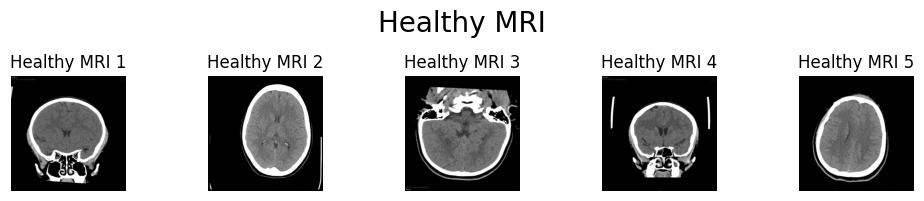

Image 1 Shape: (640, 640)
Image 2 Shape: (640, 640)
Image 3 Shape: (640, 640)
Image 4 Shape: (640, 640)
Image 5 Shape: (640, 640)


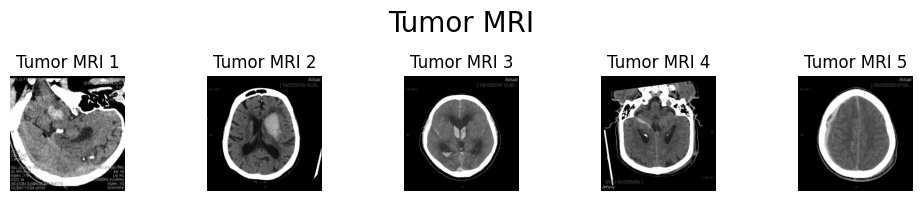

Image 1 Shape: (512, 512)
Image 2 Shape: (200, 235)
Image 3 Shape: (512, 512)
Image 4 Shape: (512, 512)
Image 5 Shape: (512, 512)


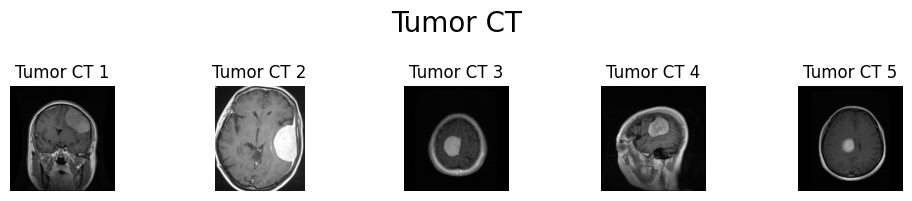

Image 1 Shape: (256, 256)
Image 2 Shape: (1024, 1024)
Image 3 Shape: (300, 168)
Image 4 Shape: (512, 512)
Image 5 Shape: (400, 442)


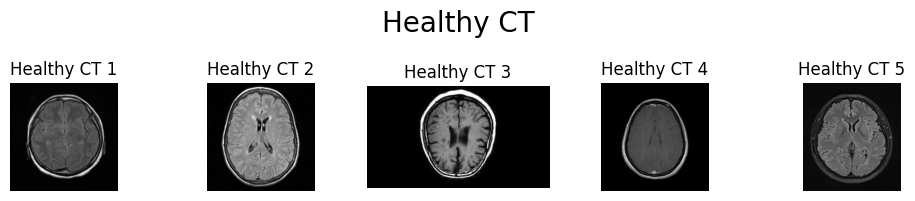

In [2]:
# ==============================
# Define Dataset Paths
# ==============================

dataset_path = "Dataset"

mri_tumor_path = os.path.join(dataset_path, "Brain Tumor CT scan Images", "Tumor")
mri_healthy_path = os.path.join(dataset_path, "Brain Tumor CT scan Images", "Healthy")
ct_tumor_path = os.path.join(dataset_path, "Brain Tumor MRI Images", "Tumor")
ct_healthy_path = os.path.join(dataset_path, "Brain Tumor MRI Images", "Healthy")

def display_images_from_path(path, title="Images", num_images=5):
    images = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(('png', 'jpg', 'jpeg'))]
    plt.figure(figsize=(10, 2))
    plt.suptitle(title, fontsize=20)
    random_images = random.sample(images, min(num_images, len(images)))
    for i, image_path in enumerate(random_images):
        img = Image.open(image_path)  
        print(f"Image {i + 1} Shape: {img.size}")
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray') 
        plt.axis('off')
        plt.title(f"{title} {i + 1}")
    plt.tight_layout()
    plt.show()
print("")

# ==============================
# Display Sample Images from Each Category
# ==============================
display_images_from_path(mri_healthy_path, title="Healthy MRI")
display_images_from_path(mri_tumor_path, title="Tumor MRI")
display_images_from_path(ct_tumor_path, title="Tumor CT")
display_images_from_path(ct_healthy_path, title="Healthy CT")


**Prosses Images**

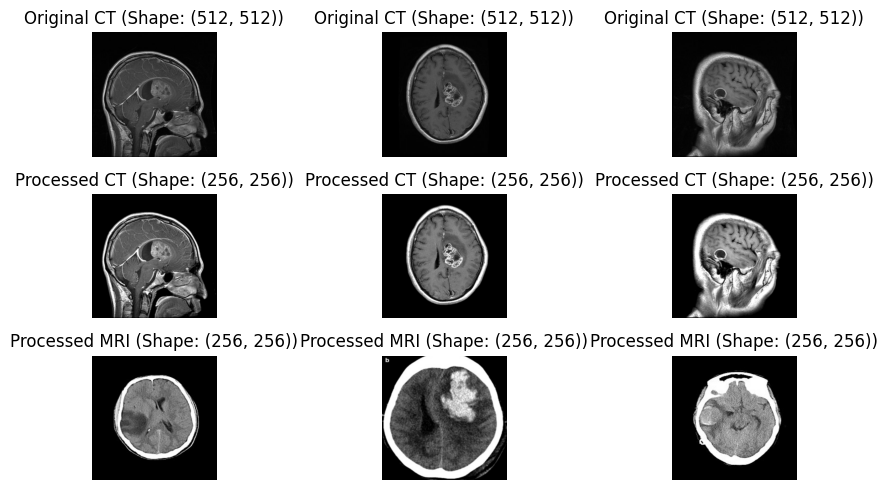

In [3]:
# ==============================
# Image Enhancement Function
# ==============================

def adjust_image(image, brightness_factor=1.2, contrast_factor=1.5, size=(256, 256), sharpness_factor=1.5):
    image = image.convert("L")
    # Enhance brightness
    enhancer_brightness = ImageEnhance.Brightness(image)
    image = enhancer_brightness.enhance(brightness_factor)
    # Enhance contrast
    enhancer_contrast = ImageEnhance.Contrast(image)
    image = enhancer_contrast.enhance(contrast_factor)
    # Enhance sharpness
    enhancer_sharpness = ImageEnhance.Sharpness(image)
    image = enhancer_sharpness.enhance(sharpness_factor)
    # Resize image
    image = image.resize(size)
    return image

def preprocess_and_display(ct_path, mri_path, output_path, size=(256, 256), num_images=3, show_images=False):
    # Load CT and MRI images
    ct_images = [os.path.join(ct_path, f) for f in os.listdir(ct_path) if f.endswith(('png', 'jpg', 'jpeg'))]
    mri_images = [os.path.join(mri_path, f) for f in os.listdir(mri_path) if f.endswith(('png', 'jpg', 'jpeg'))]

    # Process and save all images
    for i, image_path in enumerate(ct_images):
        with Image.open(image_path) as img:
            processed_img = adjust_image(img, size=size)
            processed_img.save(os.path.join(output_path, f"CT_Processed_{i}.png"), format='PNG')

    for i, image_path in enumerate(mri_images):
        with Image.open(image_path) as img:
            processed_img = adjust_image(img, brightness_factor=1, contrast_factor=1, size=size, sharpness_factor=1.5)
            processed_img.save(os.path.join(output_path, f"MRI_Processed_{i}.png"), format='PNG')

    if show_images:
        # Display CT Original and Processed
        plt.figure(figsize=(10, 5))
        for i in range(num_images):
            with Image.open(ct_images[i]) as ct_img:
                plt.subplot(3, num_images, i + 1)
                plt.imshow(ct_img, cmap='gray')
                plt.axis('off')
                plt.title(f"Original CT (Shape: {ct_img.size})")

            with Image.open(ct_images[i]) as ct_img:
                processed_ct_img = adjust_image(ct_img, size=size)
                plt.subplot(3, num_images, num_images + i + 1)
                plt.imshow(processed_ct_img, cmap='gray')
                plt.axis('off')
                plt.title(f"Processed CT (Shape: {size})")
                

        # Display MRI Processed
        for i in range(num_images):
            with Image.open(mri_images[i]) as mri_img:
                processed_mri_img = adjust_image(mri_img, brightness_factor=1, contrast_factor=1, size=size)
                plt.subplot(3, num_images, 2 * num_images + i + 1)
                plt.imshow(processed_mri_img, cmap='gray')
                plt.axis('off')
                plt.title(f"Processed MRI (Shape: {size})")
                
                
        plt.tight_layout()
        plt.show()


# ==============================
# Output Paths for Processed Images
# ==============================

output_pathT  = "Processed_Images/Tumor"
output_pathH = "Processed_Images/Healthy"

os.makedirs(output_pathT, exist_ok=True)
os.makedirs(output_pathH, exist_ok=True)

# ==============================
# Apply Preprocessing & Augmentation
# ==============================

# Process tumor images (CT and MRI)
preprocess_and_display(ct_tumor_path, mri_tumor_path, output_pathT, size=(256, 256), num_images=3, show_images=True)
# Process healthy images (CT and MRI)
preprocess_and_display(ct_healthy_path,mri_healthy_path , output_pathH, size=(256, 256), num_images=3, show_images=False)


**Augmentation**

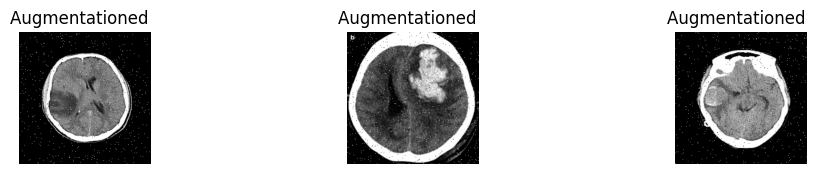

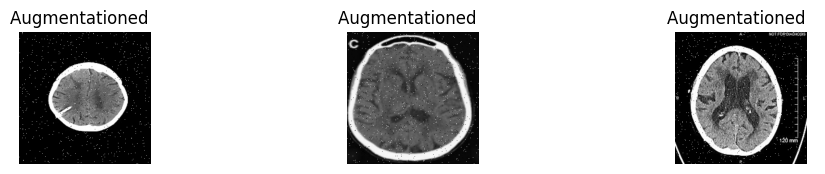

In [4]:
import os
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt

# ==============================
# Noise Augmentation Functions
# ==============================

def add_gaussian_noise(image, mean=0, std=20):
    np_image = np.array(image)
    noise = np.random.normal(mean, std, np_image.shape)
    noisy_image = np.clip(np_image + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_image)

def add_salt_and_pepper_noise(image, prob=0.02):
    np_image = np.array(image)
    noise = np.random.rand(*np_image.shape)
    np_image[noise < (prob / 2)] = 255
    np_image[noise > 1 - (prob / 2)] = 0
    return Image.fromarray(np_image)

def preprocess_and_display(ct_path, mri_path, output_path, size=(256, 256), num_images=3, show_images=False):

    ct_images = [os.path.join(ct_path, f) for f in os.listdir(ct_path) if f.endswith(('png', 'jpg', 'jpeg'))]
    mri_images = [os.path.join(mri_path, f) for f in os.listdir(mri_path) if f.endswith(('png', 'jpg', 'jpeg'))]

    # Process and save all images
    for i, image_path in enumerate(ct_images):
        with Image.open(image_path) as img:
            processed_img = adjust_image(img, size=size)
            processed_img = add_gaussian_noise(processed_img)  # Add Gaussian noise
            processed_img.save(os.path.join(output_path, f"CT_Processed_{i}_{i}.png"), format='PNG')

    for i, image_path in enumerate(mri_images):
        with Image.open(image_path) as img:
            processed_img = adjust_image(img, brightness_factor=1, contrast_factor=1, size=size, sharpness_factor=1.5)
            processed_img = add_salt_and_pepper_noise(processed_img)  # Add Salt-and-Pepper noise
            processed_img.save(os.path.join(output_path, f"MRI_Processed_{i}_{i}.png"), format='PNG')

    if show_images:
        # Display CT Original and Augmented
        plt.figure(figsize=(10, 5))
        for i in range(num_images):
            with Image.open(mri_images[i]) as mri_img:
                plt.subplot(3, num_images, 2 * num_images + i + 1)
                processed_mri_img = adjust_image(mri_img, brightness_factor=1, contrast_factor=1, size=size)
                processed_mri_img = add_salt_and_pepper_noise(processed_mri_img)
                plt.imshow(processed_mri_img, cmap='gray')
                plt.axis('off')
                plt.title(f"Augmentationed  ")
        
        plt.tight_layout()
        plt.show()

# ==============================
# Output Paths for Processed Images
# ==============================

output_pathT = "Processed_Images/Tumor"
output_pathH = "Processed_Images/Healthy"

os.makedirs(output_pathT, exist_ok=True)
os.makedirs(output_pathH, exist_ok=True)

# ==============================
# Apply Preprocessing & Augmentation
# ==============================

# Process tumor images (CT and MRI)
preprocess_and_display(ct_tumor_path, mri_tumor_path, output_pathT, size=(256, 256), num_images=3, show_images=True)

# Process healthy images (CT and MRI)
preprocess_and_display(ct_healthy_path, mri_healthy_path, output_pathH, size=(256, 256), num_images=3, show_images=True)


**Split Train&Test&Validation**

In [5]:
# ==============================
# Dataset Paths & Directories Setup
# ==============================

processed_path = "Processed_Images"
output_base_path = "Dataset_Split"
subfolders = ['train', 'val', 'test']
categories = ['Healthy', 'Tumor']

# Create necessary directories for dataset splits
for subfolder in subfolders:
    for category in categories:
        os.makedirs(os.path.join(output_base_path, subfolder, category), exist_ok=True)

# ==============================
# Function to Split & Copy Images
# ==============================
def split_and_copy_images(base_path, category_name, output_base_path, train_ratio=0.8, val_ratio=0.1):
    images = [os.path.join(base_path, f) for f in os.listdir(base_path) if f.endswith(('png', 'jpg', 'jpeg'))]
    train, temp = train_test_split(images, test_size=1 - train_ratio, random_state=42)
    val, test = train_test_split(temp, test_size=val_ratio / (1 - train_ratio), random_state=42)


    for img_path in train:
        shutil.copy(img_path, os.path.join(output_base_path, 'train', category_name))
    for img_path in val:
        shutil.copy(img_path, os.path.join(output_base_path, 'val', category_name))
    for img_path in test:
        shutil.copy(img_path, os.path.join(output_base_path, 'test', category_name))

# Apply Split for Each Category
split_and_copy_images(os.path.join(processed_path, 'Healthy'), 'Healthy', output_base_path)
split_and_copy_images(os.path.join(processed_path, 'Tumor'), 'Tumor', output_base_path)

print("Dataset has been split into Train, Validation, and Test sets.")


Dataset has been split into Train, Validation, and Test sets.


**Create DataLoder**

In [26]:
# ==============================
# Data Transformations
# ==============================

# Training Data Augmentation
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Validation & Test Data Transformation (No Augmentation)
val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# ==============================
# Dataset Loading
# ==============================

# Dataset paths
train_path = "Dataset_Split/train"
val_path = "Dataset_Split/val"
test_path = "Dataset_Split/test"

# Load datasets using ImageFolder (expects subfolders for each class)
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(val_path, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_path, transform=val_test_transform)

# ==============================
# DataLoader Creation
# ==============================

batch_size = 32
# Create DataLoaders for batch processing and shuffling
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

#Counts the number of images in each category and subset.
def count_samples(base_path, categories, subsets):
    for subset in subsets:
        print(f"Subset: {subset}")
        total_count = 0
        for category in categories:
            folder_path = os.path.join(base_path, subset, category)
            count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            total_count += count
            print(f"  Category: {category} -> {count} samples")
        print(f"  Total samples in {subset}: {total_count}\n")

# Paths and categories to count
base_path = "Dataset_Split" 
categories = ["Healthy", "Tumor"]
subsets = ["train", "val", "test"]

# Call the function
count_samples(base_path, categories, subsets)


Train dataset size: 17625
Validation dataset size: 3218
Test dataset size: 4483
Subset: train
  Category: Healthy -> 7778 samples
  Category: Tumor -> 9847 samples
  Total samples in train: 17625

Subset: val
  Category: Healthy -> 1422 samples
  Category: Tumor -> 1796 samples
  Total samples in val: 3218

Subset: test
  Category: Healthy -> 1982 samples
  Category: Tumor -> 2501 samples
  Total samples in test: 4483



In [23]:
class ConvBlock(nn.Module):
    """
    A convolutional block consisting of:
    - Convolutional Layer (3x3 kernel, stride=1, padding=1)
    - Batch Normalization (BN) for stable training
    - ReLU6 activation function (better precision for low-bit inference)
    - Dropout for regularization (prevents overfitting)
    - Max Pooling (2x2) to reduce spatial dimensions
    """

    def __init__(self, in_channels, out_channels, dropout_rate=0.2):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(),
            nn.Dropout2d(dropout_rate),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    
    def forward(self, x):
        return self.block(x) #Forward pass through the convolutional block.

class ImprovedBrainTumorCNN(nn.Module):
    """
    A Convolutional Neural Network 
    ~~~~~~~~~~~~~~
     Architecture:
    - 4 Convolutional Blocks (Conv -> BN -> ReLU6 -> Dropout -> MaxPool)
    - Global Average Pooling (Adaptive pooling for varying input sizes)
    - Fully Connected Classifier with LayerNorm instead of BatchNorm
    ~~~~~~~~~~~~~~
    Parameters:
    - in_channels (int): default: 1 for grayscale images.
    - num_classes (int): default: 2, binary classification.
    - filters (list): List of filter sizes for each convolutional block.
    - dropout_rate (float): Dropout probability for the fully connected layers.
    """

    def __init__(self, in_channels=1, num_classes=2, filters=[32, 64, 128, 256], dropout_rate=0.5):
        super(ImprovedBrainTumorCNN, self).__init__()
        
        #Define convolutional blocks with increasing filters and dropout
        self.conv1 = ConvBlock(in_channels, filters[0], dropout_rate=0.2)
        self.conv2 = ConvBlock(filters[0], filters[1], dropout_rate=0.3)
        self.conv3 = ConvBlock(filters[1], filters[2], dropout_rate=0.4)
        self.conv4 = ConvBlock(filters[2], filters[3], dropout_rate=0.5)
        
        # Global pooling and classifier
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(filters[3], 128),
            nn.LayerNorm(128),  # החלפת BatchNorm ב-LayerNorm
            nn.ReLU6(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        """
        Forward pass through the CNN.
        
        Parameters:
        - x (torch.Tensor): Input image tensor of shape (batch_size, in_channels, height, width).
        
        Returns:
        - torch.Tensor: Output logits of shape (batch_size, num_classes).
        """

        x = self.conv1(x) 
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.global_pool(x) # Compress feature maps to a fixed size
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x) # Pass through the fully connected layers
        return x


Using device: cuda


C:\Users\lidor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [1/150] Train Loss: 0.6353 Train Acc: 0.6463 Val Loss: 0.5230 Val Acc: 0.7632 LR: 0.000500
Epoch [2/150] Train Loss: 0.5703 Train Acc: 0.7150 Val Loss: 0.4624 Val Acc: 0.7943 LR: 0.000497
Epoch [3/150] Train Loss: 0.5255 Train Acc: 0.7509 Val Loss: 0.4258 Val Acc: 0.8185 LR: 0.000497
Epoch [4/150] Train Loss: 0.4980 Train Acc: 0.7685 Val Loss: 0.3993 Val Acc: 0.8341 LR: 0.000498
Epoch [5/150] Train Loss: 0.4815 Train Acc: 0.7782 Val Loss: 0.3817 Val Acc: 0.8325 LR: 0.000498
Epoch [6/150] Train Loss: 0.4601 Train Acc: 0.7915 Val Loss: 0.4203 Val Acc: 0.8170 LR: 0.000498
Epoch [7/150] Train Loss: 0.4538 Train Acc: 0.7946 Val Loss: 0.3520 Val Acc: 0.8465 LR: 0.000498
Epoch [8/150] Train Loss: 0.4414 Train Acc: 0.8047 Val Loss: 0.3424 Val Acc: 0.8502 LR: 0.000498
Epoch [9/150] Train Loss: 0.4316 Train Acc: 0.8103 Val Loss: 0.3303 Val Acc: 0.8617 LR: 0.000499
Epoch [10/150] Train Loss: 0.4216 Train Acc: 0.8141 Val Loss: 0.3261 Val Acc: 0.8658 LR: 0.000499
Epoch [11/150] Train Loss: 0.

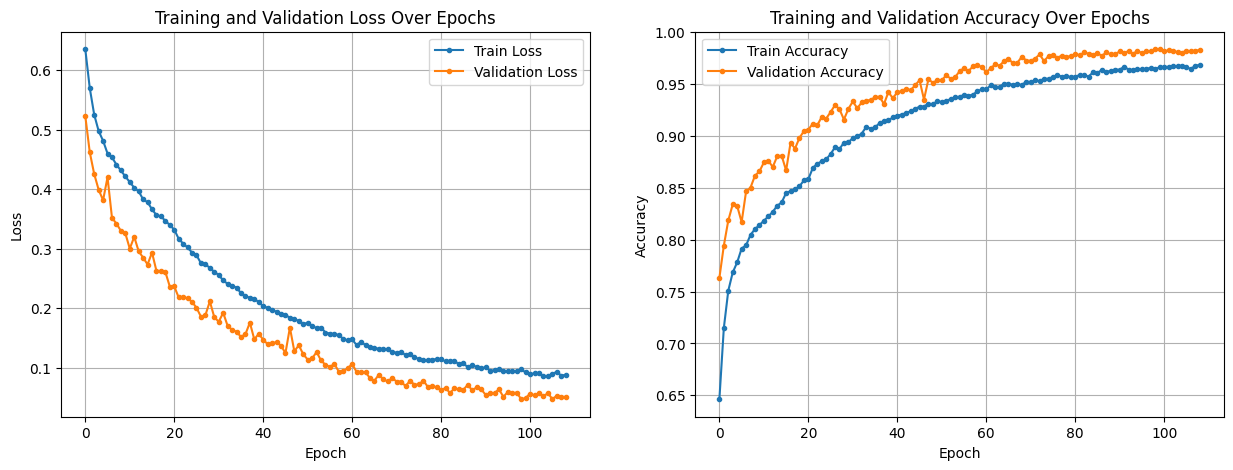

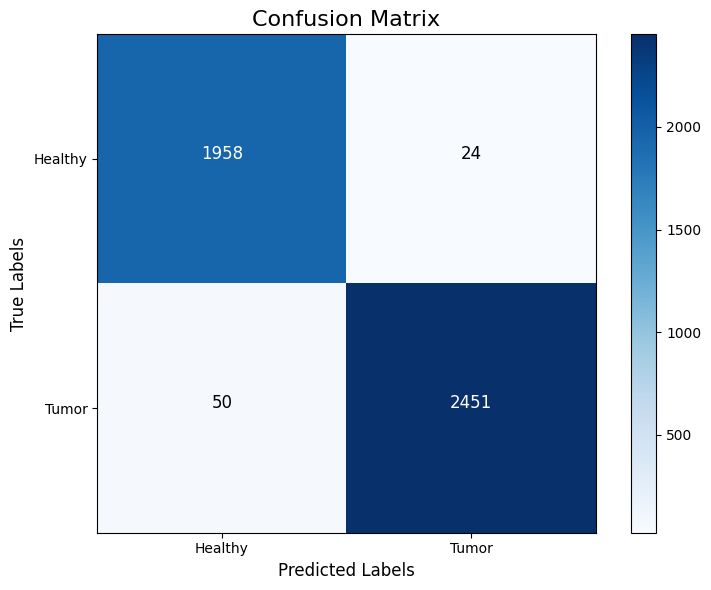

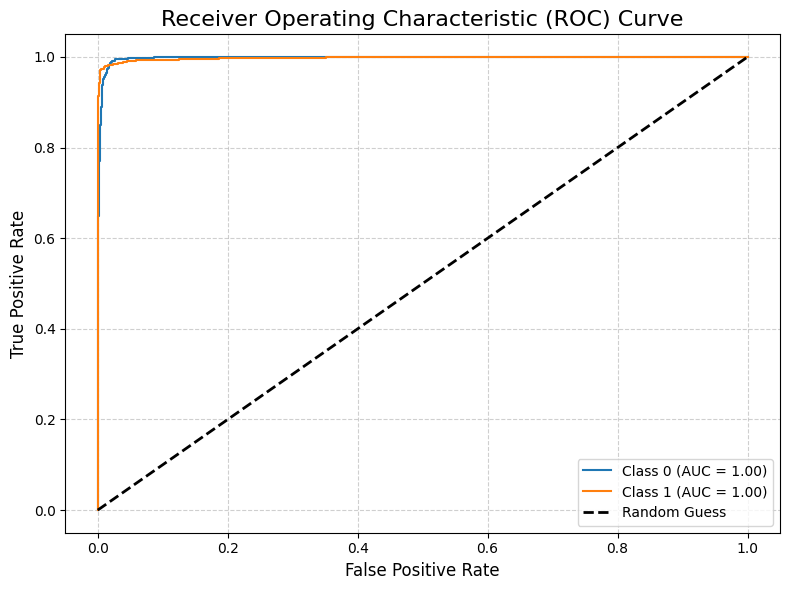


*** Model Performance Summary ***
Train Accuracy: 96.83%
Validation Accuracy: 98.26%
Test Accuracy: 98.35%
--------------------------------------------------
              precision    recall  f1-score   support

     Healthy       0.98      0.99      0.98      1982
       Tumor       0.99      0.98      0.99      2501

    accuracy                           0.98      4483
   macro avg       0.98      0.98      0.98      4483
weighted avg       0.98      0.98      0.98      4483



In [33]:
# ==============================
#  Configurations
# ==============================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

best_params = {
    "learning_rate": 0.0005,
    "dropout_rate": 0.3,
    "weight_decay": 0.01,
    "batch_size": 32,
    "filters": [64, 128, 256, 512]
}
EPOCHS = 150
BATCH_SIZE = 32
PATIENCE = 10

# ==============================
# Model Initialization
# ==============================

model = ImprovedBrainTumorCNN(in_channels=1,num_classes=2,filters=best_params["filters"],dropout_rate=best_params["dropout_rate"]).to(device)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.1328, 0.8958]).to(device))
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=10)  

# ==============================
# Training Variables
# ==============================

best_val_loss = float('inf')
early_stop_counter = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []


# ==============================
# Training Loop
# ==============================

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()

    train_loss /= total_train
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

# === Validation Phase ===

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += y_batch.size(0)
            correct_val += (predicted == y_batch).sum().item()

    val_loss /= total_val
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_accuracy:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_accuracy:.4f} "
          f"LR: {current_lr:.6f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

# ==============================
# Model Evaluation
# ==============================

model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()

test_predictions = []
test_probabilities = []
test_true_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        test_predictions.extend(predicted.cpu().numpy())
        test_probabilities.extend(probabilities.cpu().numpy())
        test_true_labels.extend(y_batch.cpu().numpy())

# ==============================
# Performance Metrics
# ==============================

test_predictions = np.array(test_predictions)
test_probabilities = np.array(test_probabilities)
test_true_labels = np.array(test_true_labels)


test_accuracy = (test_predictions == test_true_labels).mean()
print("\nPerformance Metrics:")
print("-" * 50)
print(f"Test Accuracy:       {test_accuracy:.2%}")
print("-" * 50)

# ==============================
# Visualization Functions
# ==============================

#History plot function of training and validation loss and accuracy
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", marker='o', markersize=3)  # הקטנת גודל הנקודות
    plt.plot(val_losses, label="Validation Loss", marker='o', markersize=3)  
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid()

#History plot function of training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Accuracy", marker='o', markersize=3)  # הקטנת הנקודות
    plt.plot(val_accs, label="Validation Accuracy", marker='o', markersize=3)  
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy Over Epochs")
    plt.legend()
    plt.grid()

    plt.show()

#Confusion matrix plot function
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap="Blues", interpolation='nearest')
    plt.colorbar()
    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}", horizontalalignment="center", 
                 color="white" if cm[i, j] > cm.max() / 2. else "black", fontsize=12)

    plt.xticks(np.arange(len(class_names)), class_names, fontsize=10)
    plt.yticks(np.arange(len(class_names)), class_names, fontsize=10)
    plt.grid(False)
    plt.tight_layout()
    plt.show()


#ROC curve plot function
def plot_roc_curve(true_labels, probabilities, num_classes):
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(true_labels == i, probabilities[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guess")
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=16)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Call visualization functions
plot_training_history(train_losses, val_losses, train_accs, val_accs)
plot_confusion_matrix(test_true_labels, test_predictions, ["Healthy", "Tumor"])
plot_roc_curve(test_true_labels, test_probabilities, num_classes=2)

#Classification report
print("\n*** Model Performance Summary ***")
print(f"Train Accuracy: {train_accs[-1]:.2%}")
print(f"Validation Accuracy: {val_accs[-1]:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")
print("-" * 50)
ן 
print(classification_report(test_true_labels, test_predictions, target_names=["Healthy", "Tumor"]))


## **Conclusion: Brain Tumor Detection Using Deep Learning**

Brain tumor detection is a complex task requiring **high precision and efficiency**. In this project, we developed a **Convolutional Neural Network (CNN)** to classify **MRI and CT scans** into *Healthy* and *Tumor* categories. By optimizing model architecture, regularization, and training techniques, we achieved **state-of-the-art performance**.

---

### **🔬 Model Performance & Key Results**  
Our CNN architecture demonstrated **exceptional accuracy** across datasets:  

$$
\text{Train Accuracy: } 96.8\%, \quad
\text{Validation Accuracy: } 98.3\%, \quad
\text{Test Accuracy: } 98.4\%
$$

Further analysis using the **Confusion Matrix and ROC Curve** confirmed high **Precision**, **Recall**, and **F1-Scores**, ensuring robust and reliable predictions.

---

### **🚀 Optimizations & Enhancements**  
Several improvements played a key role in boosting performance:  
- **Data Augmentation**: *Rotations, flips, contrast adjustments, and blurring* improved generalization.  
- **Regularization**: *Dropout ($p=0.3$–$0.5$), Weight Decay ($\lambda=0.01$)* minimized overfitting.  
- **Optimized Learning**: *AdamW optimizer* with **Cosine Annealing LR** enabled smooth convergence.  
- **Early Stopping**: Prevented unnecessary training cycles when no further improvement was detected.  

---

### **🔭 Future Work**  
Despite strong results, further improvements can be made:  
- **Attention Mechanisms**: SE-Blocks or Vision Transformers for enhanced feature extraction.  
- **Ensemble Models**: Combining multiple architectures for improved robustness.  
- **Larger Datasets**: Training on diverse MRI scans from multiple sources for better generalization.  

---

### **🏥 Final Thoughts**  
This study demonstrates the **potential of AI in medical diagnostics**. Our model provides an efficient, scalable, and highly accurate tool for brain tumor detection, with the potential for clinical integration.  

AI-powered diagnostics can revolutionize healthcare, enabling faster and more accurate disease detection.

